<a href="https://colab.research.google.com/github/ShreshthSaxena/Algorithmic-Trading/blob/master/SingleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install quandl

In [0]:

import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math, time
import tensorflow as tf

**DATA GATHERING**

In [39]:
from pandas_datareader import data as pdr
import fix_yahoo_finance

snp_data = pdr.get_data_yahoo('^GSPC', start=datetime.datetime(2000, 1, 4), end=datetime.datetime(2017, 7, 27))
snp_data = snp_data.drop(['High','Close','Low', 'Open', 'Volume'],1)
snp_data.head()

,Adj Close
Date,
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
2000-01-10,1457.599976


In [38]:
import pandas_datareader
nasdaq = pandas_datareader.nasdaq_trader.get_nasdaq_symbols(retry_count=3, timeout=30, pause=None)
nasdaq.head()

,Nasdaq Traded,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
Symbol,,,,,,,,,,,
A,True,"Agilent Technologies, Inc. Common Stock",N,,False,100.0,False,NaN,A,A,False
AA,True,Alcoa Corporation Common Stock,N,,False,100.0,False,NaN,AA,AA,False
AAAU,True,Perth Mint Physical Gold ETF,P,,True,100.0,False,NaN,AAAU,AAAU,False
AABA,True,Altaba Inc. - Common Stock,Q,Q,False,100.0,False,N,NaN,AABA,False
AAC,True,"AAC Holdings, Inc. Common Stock",N,,False,100.0,False,NaN,AAC,AAC,False


In [40]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'AMZN', 'CSCO', 'ADBE', 'AMGN', 'NVDA', 'SBUX', 'ASML', 'GILD']
all_data = get(tickers, datetime.datetime(2000, 1, 4), datetime.datetime(2017, 7, 27))

all_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,44190.000000,44190.000000,44190.000000,44190.000000,4.419000e+04,44190.000000
mean,53.682041,52.416926,53.062888,53.067752,3.115848e+07,48.951830
std,91.943761,90.322117,91.188382,91.184721,5.088124e+07,91.266430
min,0.942143,0.908571,0.927857,0.937143,0.000000e+00,0.624890
25%,17.170000,16.530001,16.870001,16.876667,5.508250e+06,13.808631
50%,28.250000,27.566250,27.910000,27.914532,1.260745e+07,22.690001
75%,58.299999,57.049999,57.619999,57.669998,3.763510e+07,50.179255
max,1083.310059,1043.199951,1069.550049,1052.800049,1.855410e+09,1052.800049


In [41]:
d=all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
d

Ticker,AAPL,ADBE,AMGN,AMZN,ASML,CSCO,GILD,MSFT,NVDA,SBUX
Date,,,,,,,,,,
2000-01-04,2.440975,14.791295,48.689911,81.937500,26.826624,40.324173,1.513320,40.692646,3.506938,2.393081
2000-01-05,2.476697,15.083735,50.365246,69.750000,26.085730,40.200638,1.501003,41.121727,3.391485,2.424404
2000-01-06,2.262367,15.206868,51.202930,65.562500,24.480459,39.533516,1.603064,39.744217,3.170195,2.512110
2000-01-07,2.369532,15.945663,56.961960,69.562500,25.036133,41.856102,1.847659,40.263588,3.223112,2.499581
2000-01-10,2.327857,16.561329,60.417358,69.187500,27.413177,43.412739,2.088733,40.557178,3.328946,2.606078
2000-01-11,2.208785,15.422350,55.653084,66.750000,26.517927,42.103184,1.897808,39.518398,3.194248,2.530903
2000-01-12,2.076318,15.345394,53.244766,63.562500,27.011856,41.040722,1.881092,38.231228,3.112468,2.537168
2000-01-13,2.304043,16.161148,55.967213,65.937500,28.200378,41.979649,1.984913,38.953846,3.242355,2.718842
2000-01-14,2.391858,16.330452,57.223717,64.250000,30.901564,42.523228,1.939162,40.557178,3.381863,2.649931


In [57]:
d.corrwith(snp_data['Adj Close'], axis=0, drop=False).sort_values(ascending = False)

Ticker
ASML    0.939346
ADBE    0.931655
AMGN    0.920196
MSFT    0.920161
SBUX    0.913389
AAPL    0.899090
AMZN    0.870971
GILD    0.861092
NVDA    0.694488
CSCO    0.489332
dtype: float64

**NORMALIZATION**

In [46]:
norm_d=(d-d.min())/(d.max()-d.min())
snp_data = (snp_data-snp_data.min())/(snp_data.max()-snp_data.min())
print(snp_data.shape, norm_d.shape)

(4419, 1) (4419, 10)


**TRAIN - TEST SPLIT**

In [0]:
train_snp = snp_data[:'2007-12-31']
test_snp = snp_data['2008-1-2':]
train_d = d[:'2007-12-31']
test_d = d['2008-1-2':]
print(train_d.shape, test_d.shape)

(2009, 10) (2410, 10)


**SINGLENET**

In [0]:
def create_dataset(dataset, look_back = 20):
  dataX,dataY = [],[]
  print(dataset.shape)
  for i in range(len(dataset) - look_back -1):
    a = dataset.iloc[i:(i+look_back),0]
    dataX.append(a)
    dataY.append(dataset.iloc[i + look_back,0])
  return np.array(dataX),np.array(dataY)

look_back = 20
trainX, trainY = create_dataset(train_snp, look_back)
testX, testY = create_dataset(test_snp, look_back)

(2009, 1)
(2410, 1)


In [0]:
testX.shape

(2389, 20)

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(4, activation='relu', input_shape=(1, look_back), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))        
    
    #adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print("Compilation Time : ", time.time() - start)
    return model

In [0]:
model = build_model(look_back)

history = model.fit(trainX,trainY,batch_size=500,epochs=400,validation_split=0.2,verbose=1)

Compilation Time :  0.03136563301086426
Instructions for updating:
Use tf.cast instead.
Train on 1590 samples, validate on 398 samples
Epoch 1/400
1590/1590 [==============================] - 1s 923us/step - loss: 0.0797 - mean_squared_error: 0.0797 - val_loss: 0.1703 - val_mean_squared_error: 0.1703
Epoch 2/400
1590/1590 [==============================] - 0s 13us/step - loss: 0.0774 - mean_squared_error: 0.0774 - val_loss: 0.1661 - val_mean_squared_error: 0.1661
Epoch 3/400
1590/1590 [==============================] - 0s 12us/step - loss: 0.0748 - mean_squared_error: 0.0748 - val_loss: 0.1618 - val_mean_squared_error: 0.1618
Epoch 4/400
1590/1590 [==============================] - 0s 12us/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.1573 - val_mean_squared_error: 0.1573
Epoch 5/400
1590/1590 [==============================] - 0s 12us/step - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 0.1527 - val_mean_squared_error: 0.1527
Epoch 6/400
1590/1590 [===========

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


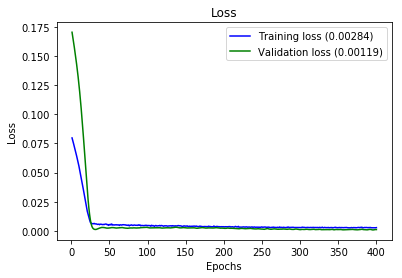

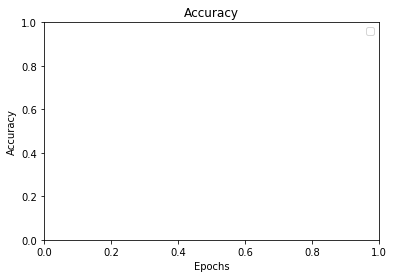

In [0]:
plot_history(history)

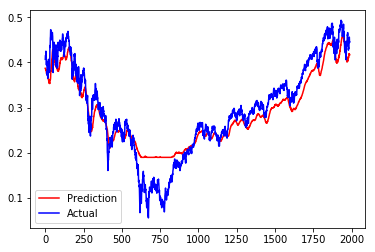

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(model.predict(trainX),color='red', label='Prediction')
plt2.plot(trainY,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

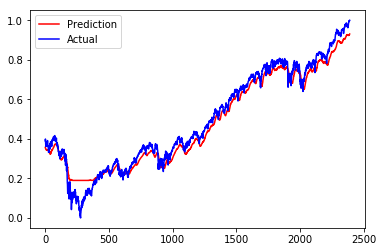

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(model.predict(testX),color='red', label='Prediction')
plt2.plot(testY,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()